<a href="https://colab.research.google.com/github/daviddralle/cannabit/blob/main/Cannabit_phil_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install and load the R packages that will be used in this script

In [4]:
#Install the packages
install.packages("dataRetrieval")
install.packages("tidyverse")
install.packages("lubridate")
install.packages("pillar")
install.packages("ellipsis")
install.packages("vctrs")
install.packages("lme4")
install.packages("cowplot")
##load the packages
library(dataRetrieval)
library(tidyverse)
library(lubridate)
library(pillar)
library(ellipsis)
library(vctrs)
library(lme4)
library(cowplot)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘rbibutils’, ‘Rdpack’, ‘minqa’, ‘nloptr’, ‘reformulas’, ‘RcppEigen’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr   

In [5]:
## download and load the flow data for both streams code to download flow data from the USGS Elder gauge site and create a new dataframe
#discharge in cubic feet per second
Elder_raw <- readNWISuv(siteNumbers = "11475560",
                        parameterCd = "00060",
                        startDate = "2014-01-01",
                        endDate = "2021-11-20")

##  add a column for year, renames X_00060_00000 to flow, and filter the dates to the desired interval, fir DOY need to make the year one year ahead of all the data you have, change year to categorical , subset to the dates you want, add a colum for water year
#elder is 16.97 km sq drainage
# 86400 seconds per day
# 0.0283168 meter ^3 per cubic foot
# 1000000 square m per sqaure km
Elder_flow <- Elder_raw %>%
  mutate(year = year(dateTime),
         DOYtime = make_datetime(2050, month(dateTime), mday(dateTime), hour(dateTime), minute(dateTime)),
         date = make_date(year(dateTime), month(dateTime), mday(dateTime)),
         year = factor(year),
         wyear =  ifelse(month(date) >= 10, year(date)+1, year(date)),
         wyear = factor(wyear)) %>%
  rename(discharge_cfs = X_00060_00000) %>%
  filter(date >= "2015-12-01"& date <= "2019-11-01") %>%
  mutate(discharge_mm_day = discharge_cfs * 86400 * 0.0283168 * (1/(16.97 * 1000000)) * 1000,
         month = month(date),
         year = year(date))
# read in the dry creek data
dry_creek_flow <- read.csv("https://raw.githubusercontent.com/daviddralle/cannabit/refs/heads/main/20211201_dry_discharge_daily.csv") %>%
  mutate(date = date(Date)) %>%
  mutate(month = month(date),
         year = year(date))
# monthly summaries of both creeks
#dry
dry_creek_monthly <- dry_creek_flow %>%
  group_by(month, year) %>%
  summarise(mean_daily_q_mm_day = mean(runoff)) %>%
  mutate(creek = "Dry Creek")
#elder
elder_monthly <- Elder_flow %>%
  group_by(month, year) %>%
  summarise(mean_daily_q_mm_day = mean(discharge_mm_day)) %>%
  mutate(creek = "Elder")
##merge the two stream datasets
elder_dry_montly <- rbind(dry_creek_monthly, elder_monthly)

#dataframe with both Elder and Dry and daily values of flow
dry_creek_flow_daily <- dry_creek_flow %>%
  select(date, year, month, runoff) %>%
  rename(runoff_mm_day = runoff) %>%
  mutate(stream = "Dry Creek",
         flow_date = make_date(2050, month(date), mday(date)),
         year = factor(year),
         wyear =  ifelse(month(date) >= 10, year(date)+1, year(date)),
         wyear = factor(wyear))

elder_flow_daily <- Elder_flow %>%
  group_by(date, year, month) %>%
  summarize(runoff_mm_day = mean(discharge_mm_day)) %>%
  mutate(stream = "Elder",
         flow_date = make_date(2050, month(date), mday(date)),
         year = factor(year),
         wyear =  ifelse(month(date) >= 10, year(date)+1, year(date)),
         wyear = factor(wyear))

both_streams_daily = rbind(dry_creek_flow_daily, elder_flow_daily)

GET: https://nwis.waterservices.usgs.gov/nwis/iv/?site=11475560&format=waterml,1.1&ParameterCd=00060&startDT=2014-01-01&endDT=2021-11-20

`summarise()` has grouped output by 'month'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'month'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'date', 'year'. You can override using the
`.groups` argument.


In [7]:
##### cannabis farm use  ######
### start by reading in the data for farm level water use
## format column values and convert use estimates from m^3/month to mm/day. Columns that end in xxxx_phil are use estimates assuming no storage at the farm
## (M^3/MONTH) * (1/cultivation area M^2) * (1month/ # days in month) * (1000mm/1m)
farm_water_use <- read.csv("https://raw.githubusercontent.com/daviddralle/cannabit/refs/heads/main/20240621_Cannabis%20Farm%20Annual%20and%20Monthly%20Water%20Prediction%20Totals_Phil%20Task.csv") %>%
  mutate(JanWU_mm_day = JanWE_Pred_FullData * (1/CultvArea) * (1000) * (1/31),
         FebWU_mm_day = FebWE_Pred_FullData * (1/CultvArea) * (1000) * (1/28),
         MarWU_mm_day = MarWE_Pred_FullData * (1/CultvArea) * (1000) * (1/31),
         AprWU_mm_day = AprWE_Pred_FullData * (1/CultvArea) * (1000) * (1/30),
         MayWU_mm_day = MayWE_Pred_FullData * (1/CultvArea) * (1000) * (1/31),
         JunWU_mm_day = JunWE_Pred_FullData * (1/CultvArea) * (1000) * (1/30),
         JulWU_mm_day = JulWE_Pred_FullData * (1/CultvArea) * (1000) * (1/31),
         AugWU_mm_day = AugWE_Pred_FullData * (1/CultvArea) * (1000) * (1/31),
         SepWU_mm_day = SepWE_Pred_FullData * (1/CultvArea) * (1000) * (1/30),
         OctWU_mm_day = OctWE_Pred_FullData * (1/CultvArea) * (1000) * (1/31),
         NovWU_mm_day = NovWE_Pred_FullData * (1/CultvArea) * (1000) * (1/30),
         DecWU_mm_day = DecWE_Pred_FullData * (1/CultvArea) * (1000) * (1/31))

#convert this into a "long dataframe and rename the months to graph
farm_water_use_long <- farm_water_use %>%
  select(ID, Catchment, CultvArea, WatershedHUC12, PropOutdoor, RefET, AvgAspect, JanWU_mm_day, FebWU_mm_day, MarWU_mm_day, AprWU_mm_day, MayWU_mm_day, JunWU_mm_day, JulWU_mm_day, AugWU_mm_day, SepWU_mm_day, OctWU_mm_day, NovWU_mm_day, DecWU_mm_day) %>%
  gather(use_month, use_mm_day, JanWU_mm_day:DecWU_mm_day) %>%
  mutate(month = substr(use_month, 1, 3)) %>%
  select(-use_month) %>%
  mutate(month_abrev = factor(month, levels = c("Jan","Feb", "Mar", "Apr", "May","Jun","Jul", "Aug", "Sep", "Oct", "Nov", "Dec"))) %>%
  mutate(month = case_when(month_abrev == "Jan" ~ 1,
                                  month_abrev == "Feb" ~ 2,
                                  month_abrev == "Mar" ~ 3,
                                  month_abrev == "Apr" ~ 4,
                                  month_abrev == "May" ~ 5,
                                  month_abrev == "Jun" ~ 6,
                                  month_abrev == "Jul" ~ 7,
                                  month_abrev == "Aug" ~ 8,
                                  month_abrev == "Sep" ~ 9,
                                  month_abrev == "Oct" ~ 10,
                                  month_abrev == "Nov" ~ 11,
                                  month_abrev == "Dec" ~ 12))

## make a dataframe for export that sumarises reported use, and estimated use data by month
monthly_use <- farm_water_use_long %>%
  group_by(month) %>%
  summarise(use_25_monthly_mm_day = quantile(use_mm_day, 0.25),
            use_median_monthly_mm_day = median(use_mm_day),
            use_75_monthly_mm_day = quantile(use_mm_day, 0.75),
            use_90_monthly_mm_day = quantile(use_mm_day, 0.9),
            use_95_monthly_mm_day = quantile(use_mm_day, 0.95))

#convert to long format to later merge with discharge data from Elder and Dry
monthly_use_long <- farm_water_use_long %>%
  group_by(month) %>%
  summarise(modeled_use_mm_day = quantile(use_mm_day, c(0.25,0.5,0.75,.9, 0.95))) %>%
  mutate(quantile = rep(c(0.25,0.5,0.75,.9, 0.95), ))

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'month'. You can override using the
`.groups` argument.


Figure S1 panel A: boxplot of use use and month, y axis log scaled

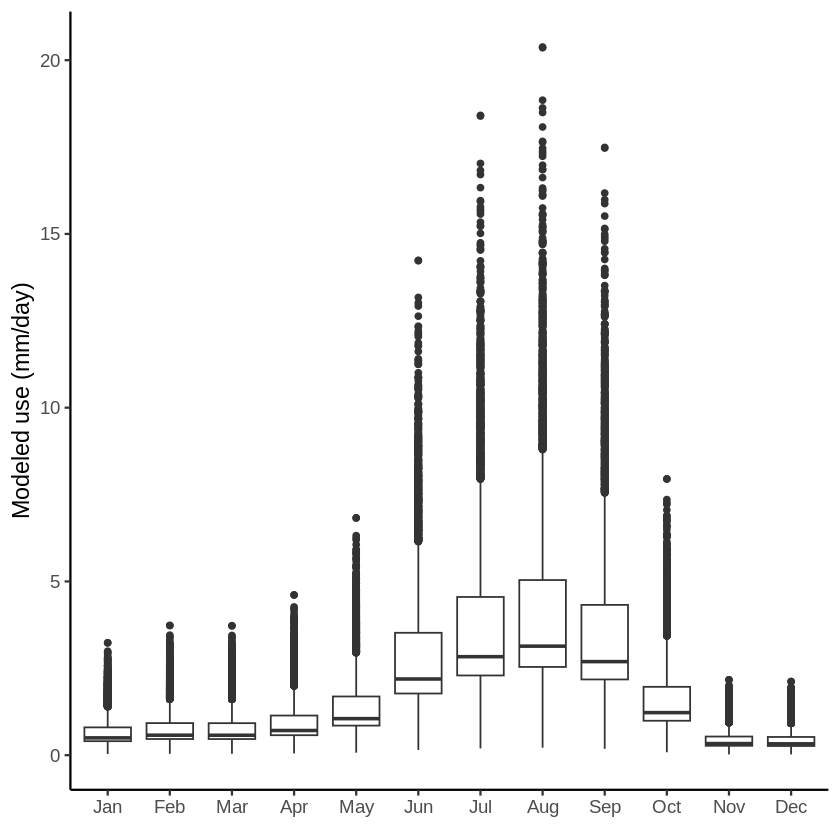

In [8]:

predicted_farm_use <- ggplot(data = farm_water_use_long, aes(x = as.factor(month_abrev), y = use_mm_day))+
  geom_boxplot()+
  theme_classic(base_size = 14)+
  ylab("Modeled use (mm/day)")+
  #scale_y_log10()+
  xlab(element_blank())+
  theme(legend.position = "none")
predicted_farm_use
#ggsave("20240917_predicted_farm_use_noLog_Y.png", plot = predicted_farm_use, width =9, height = 6, dpi = 900)

Figure S1 Panel B

NULL

Warning message in geom_point(aes(x = median_water, y = 0.85), colour = "blue", :
“All aesthetics have length 1, but the data has 7115 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_point(aes(x = water75, y = 0.85), colour = "blue", size = 2):
“All aesthetics have length 1, but the data has 7115 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_point(aes(x = water90, y = 0.85), colour = "blue", size = 2):
“All aesthetics have length 1, but the data has 7115 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_point(aes(x = water95, y = 0.85), colour = "blue", size = 2):
“All aesthetics have length 1, but the data has 7115 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
`stat_bin()` using `bins = 30`. Pick

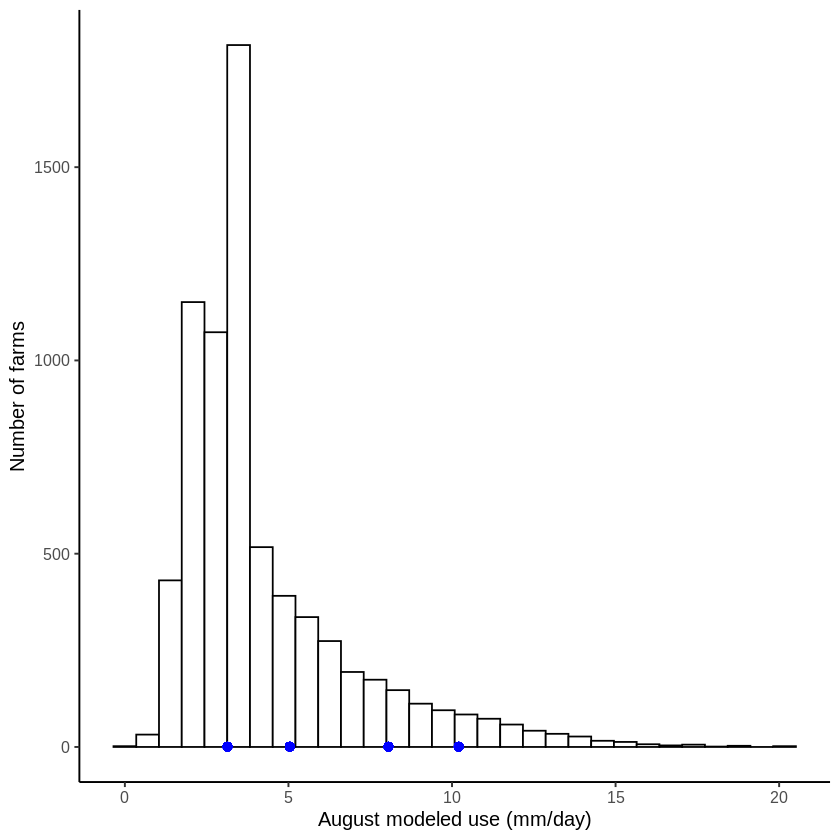

In [9]:
## find percentiles of water use for August
levels((farm_water_use_long$month))
aug_water <- farm_water_use_long %>%
  filter(month == 8)
water25 <- quantile(aug_water$use_mm_day, 0.25)
median_water <- quantile(aug_water$use_mm_day, 0.5)
water75 <-  quantile(aug_water$use_mm_day, 0.75)
water90 <-  quantile(aug_water$use_mm_day, 0.9)
water95 <-  quantile(aug_water$use_mm_day, 0.95)

## Figure S1 Panel B: histogram of August water use
august_use <- ggplot(data = filter(farm_water_use_long, month == 8), aes(x = use_mm_day))+
  geom_histogram(color="black", fill="white")+
  #scale_y_continuous(trans='log10')+
  theme_classic(base_size = 12)+
  xlab("August modeled use (mm/day)") +
  ylab("Number of farms")+
  geom_point(aes(x=median_water, y=0.85), colour="blue", size = 2) +
  geom_point(aes(x=water75, y=0.85), colour="blue", size = 2)+
  geom_point(aes(x=water90, y=0.85), colour="blue", size = 2)+
  geom_point(aes(x=water95, y=0.85), colour="blue", size = 2)

august_use
#ggsave("20240917_august_predicted_use.png", plot = august_use, width =5, height = 3, dpi = 900)

Cannabis coverage on the landscape

Rows: 1604 Columns: 65
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (65): Catchment_ID, Catchment_Area, Cannabis_Area, Cann_Percent_Cover, J...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


10%       25%       50%       75%       90%       95% 
0.5892001 1.2530967 2.1903095 3.6897601 5.9118010 7.4147292

25%        50%        90%        95%        99% 
0.02104054 0.07811220 0.42595056 0.66626184 1.77737801

[1] 13.05941

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 18 rows containing missing values or values outside the scale range
(`geom_bar()`).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


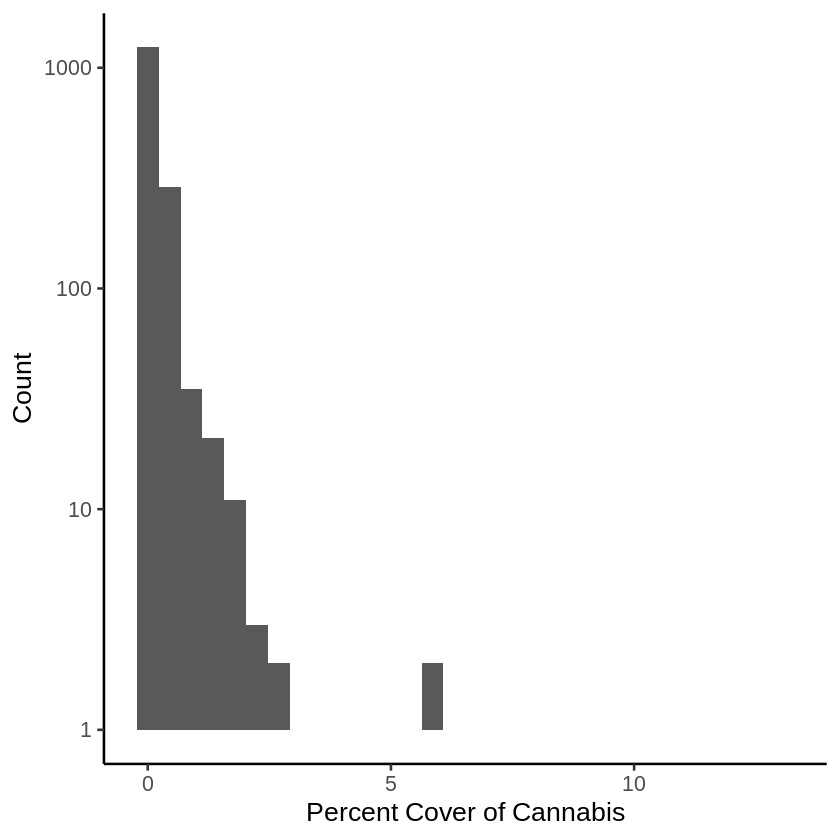

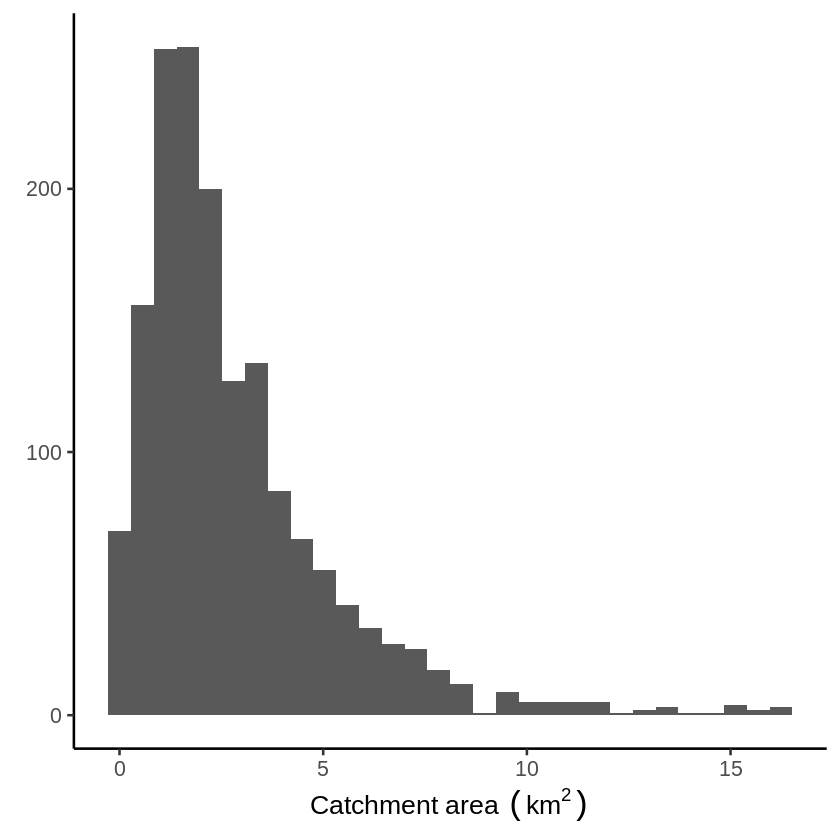

In [11]:
 ##Figure S2##
## updated 2024 06 10 to look at the sizes of grows and areal coverage of farms in Butsic et al. 2018 in Mendocino and Humboldt
cannabis_area <- read_csv("https://raw.githubusercontent.com/daviddralle/cannabit/refs/heads/main/20240405_Full_Catchment_Statistics.csv") %>%
  mutate(catchment_area_sqkm = Catchment_Area / 1000000,
         cannabis_area_sqkm = Cannabis_Area/ 1000000) %>%
  mutate(percent_cover = ((cannabis_area_sqkm/catchment_area_sqkm)*100))
## some summaries
quantile(cannabis_area$catchment_area_sqkm, c(.1, .25, .5,.75,.9,.95))
quantile(cannabis_area$percent_cover, c(.25, .5,.9,.95,.99))
max(cannabis_area$percent_cover)

## Figure S2 Panel A histogram percent cover of catchments
cannabis_pct_cover_hist <- ggplot(data = cannabis_area, (aes(x = percent_cover))) +
  geom_histogram()+
  xlab('Percent Cover of Cannabis') +
  ylab("Count")+
  scale_y_log10()+
  theme_classic(base_size = 16)
cannabis_pct_cover_hist
#ggsave("202400917_cannabis_pct_cover_hist.png", plot = cannabis_pct_cover_hist, width = 5, height = 4, dpi = 900)

## Figure S2 PanelB histogram of catchment size
catchment_size_hist <- ggplot(data = cannabis_area, (aes(x = catchment_area_sqkm))) +
  geom_histogram()+
  xlab(bquote('Catchment area '(km^2))) +
  ylab(element_blank())+
  #scale_y_log10()+
  theme_classic(base_size = 16)
catchment_size_hist
#ggsave("20240917_catchment_size_hist.png", plot = catchment_size_hist, width = 5, height = 4, dpi = 900)

Summaries for number of zero-flow days, additional zero-flow days, and reduction in summer flow

In [ ]:
###### Regressions for effect size calculations########
# set working directory
setwd("/Users/Philip/Dropbox/Data/BCC_project")
scenario_data <- read.csv("/Users/Philip/Dropbox/Data/BCC_project/files_from_david/20241212_cannaphil_sims.csv") %>%
  select(X, use, impQ, natQ, source, q0, c, g, u)
##reformat the data to have one column for each response variable and each predictor variable

## make a dataframe that has only Q, not Qnat or Q imp and rows for zero cannabis cover
natQ <- scenario_data %>%
  filter(u == 0.5,
         c == 0.1) %>%
  select(X, natQ, source, q0, g) %>%
  mutate(c = 0,
         u = NA,
         impQ = natQ,
         use = NA) %>%
  select(X, use, impQ, natQ, source, q0, c, g, u)

## merge the natQ dataframe, which contains the zero cannabis cover flow rows for all the initial conditions and both gauges with the full dataset
### also filter for the parameter values that were chosen for the scenarios
scenario_data_all <- scenario_data %>%
  rbind(natQ) %>%
  mutate(g = as.factor(g),
         X = ymd(X)) %>%
  filter(c %in% c(0, 0.01, 0.05, 0.1, 0.5, 1, 5, 10),
         q0 %in% c(0.1, 0.5, 1, 5, 10))

####### Figure 2: Plot representative synthetic hydrographs
### select the levels for the scenarios that will be plotted
example_hydro <- scenario_data_all %>%
  mutate(year = year(X)) %>%
  filter(q0 == 1,
         c == 5.0,
         u == 0.9)

natQ_example_hydro <- example_hydro %>%
  select(X, natQ, g) %>%
  rename(discharge = natQ) %>%
  mutate(source = "unimpaired")
#cannabis water use
use_example_hydro <-example_hydro %>%
  select(X, use, g) %>%
  rename(discharge = use) %>%
  mutate(source = "use")
# impaired for both groundwater and surface diversion
impaired_example_hydro <- example_hydro %>%
  select(X ,impQ,g, source) %>%
  rename(discharge = impQ)
#recombine in long format for plotting
example_hydro_all <- rbind(natQ_example_hydro, use_example_hydro, impaired_example_hydro) %>%
  mutate(stream = case_when(g == 0 ~ "Dry Creek",
                            g == 11475560 ~ "Elder Creek"))

## plot hydrographs
hydro_example_plot = ggplot(data = example_hydro_all, aes(y = discharge, x = X, color = source)) +
  geom_line(size = 1.3)+
  facet_grid(~stream,)+
  xlab(element_blank()) +
  ylab("mm/day")+
  theme_classic(base_size = 14)

hydro_example_plot
ggsave("20241213_example_synthetic_hydro_c5_q1_u.9.png", plot = hydro_example_plot, width =8, height = 5, dpi = 900)

## make a dataframe that calculates the % reduction in summer flow and number of days with zero flow
reduction_summer_flow <- scenario_data_all %>%
  group_by(source, q0, c , g, u) %>%
  summarise(natQ_total = sum(natQ),
            impQ_total = sum(impQ),
            zero_flow_days_natQ = sum(natQ == "0"),
            zero_flow_days_impQ = sum(impQ == "0")) %>%
  mutate(percent_reduction_summer_flow = ((natQ_total- impQ_total)/ natQ_total)*100,
         additional_zero_flow = (zero_flow_days_impQ - zero_flow_days_natQ),
         mm_depletion = (natQ_total - impQ_total))

## sort this dataframe to emphasize the low impact scenarios first and the higher impact scenarios later
summer_flow_table <- reduction_summer_flow %>%
  filter(c == "1",
         u == "0.5",
         source == "surface",
         zero_flow_days_impQ > 0) %>%
  arrange( c, q0, u, source )

## Figure 3: Summary plots for median water users for percent reduction in summer flow and number of days with zero flow

summer_flow_summary <- reduction_summer_flow %>%
  filter(u == 0.50) %>%
  group_by(c, g, source) %>%
  summarise(mean_summer_reduction = mean(percent_reduction_summer_flow),
            sd_summer_reduction = sd(percent_reduction_summer_flow),
            mean_aditional_zero_flow = mean(additional_zero_flow),
            sd_additional_zero_flow = sd(additional_zero_flow)) %>%
  mutate(stream = case_when(g == 0 ~ "Dry Creek",
                            g==11475560 ~"Elder Creek"))


### Figure 3: combined faceted plot for additional zero flow days and percent reduction in summer flow
# Prepare data for additional zero-flow days
additional_zero_flow_combined <- summer_flow_summary %>%
  mutate(
    parameter_estimate = mean_aditional_zero_flow,
    std_error = sd_additional_zero_flow,
    response = "Additional zero-flow days"
  ) %>%
  select(stream, c, source, response, parameter_estimate, std_error)

# Prepare data for percent reduction in summer discharge
percent_reduction_combined <- summer_flow_summary %>%
  mutate(parameter_estimate = mean_summer_reduction,
         std_error = sd_summer_reduction,
         response = "Percent reduction in summer discharge") %>%
  select(stream, c, source, response, parameter_estimate, std_error)

# Combine the datasets
combined_summary <- rbind(additional_zero_flow_combined, percent_reduction_combined)

# Create the combined faceted plot
combined_summary_plot <- ggplot(data = combined_summary, aes(y = parameter_estimate, x = c, group = source)) +
  geom_errorbar(size = 0.3,
                aes(ymin = ifelse(parameter_estimate - std_error < 0, 0, parameter_estimate - std_error),
                    ymax = parameter_estimate + std_error,
                    width = 0.1),
                position = position_dodge(width = 0.1)) +
  geom_path(size = 1.1, aes(linetype = source), position = position_dodge(width = 0.1)) +
  geom_point(size = 3, aes(shape = source), position = position_dodge(width = 0.1)) +
  theme_minimal(base_size = 14) +
  theme(strip.background = element_blank()) +
  facet_grid(response ~ stream, scales = "free_y") +
  labs(linetype = NULL,
       shape = NULL,
       x = "Percent areal coverage of cannabis agriculture",
       y = element_blank())

# Print and save the plot
combined_summary_plot
ggsave("20241213_combined_summary_plot.png", plot = combined_summary_plot, width = 8, height = 8, dpi = 900)

Effect size calculation using regressions and associated plots

In [ ]:
## Regressions to get parameter estimates for each of the explanatory variables to use as effect sizes, different models for each stream
##total summer flow
summer_flow_model_elder <- lm(data = filter(reduction_summer_flow, g == "11475560"), impQ_total ~ source + q0 + c + u)
summary(summer_flow_model_elder)

summer_flow_model_dry <- lm(data = filter(reduction_summer_flow, g == "0"), impQ_total ~ source + q0 + c + u)
summary(summer_flow_model_dry)

## number of days with zero flow
zero_flow_days_model_elder <-lm(data = filter(reduction_summer_flow, g == "11475560"), zero_flow_days_impQ ~ source + q0 + c + u  )
summary(zero_flow_days_model_elder)

zero_flow_days_model_dry <-lm(data = filter(reduction_summer_flow, g == "0"), zero_flow_days_impQ ~ source + q0 + c+ u )
summary(zero_flow_days_model_dry)

#additional days with zero flow
additional_zero_flow_days_model_elder <- lm(data = filter(reduction_summer_flow, g == "11475560"), additional_zero_flow ~ source + q0 + c + u )
summary(zero_flow_days_model_dry)

additional_zero_flow_days_model_dry <- lm(data = filter(reduction_summer_flow, g == "0"), additional_zero_flow ~ source + q0 + c + u )
summary(zero_flow_days_model_dry)

# extract parameter estimates, names and std error as vectors and make them into a dataframe for each model
## effect size plot for summer flow
#extract everything for elder and make it into a dataframe
summer_flow_parameters_elder <- names(summer_flow_model_elder$coefficients)
summer_flow_estimates_elder <- summer_flow_model_elder$coefficients
summer_flow_std_error_elder <- sqrt(diag(vcov(summer_flow_model_elder)))
summer_flow_effect_size_elder <- tibble(
  parameter_names = summer_flow_parameters_elder,
  estimates = summer_flow_estimates_elder,
  std_error = summer_flow_std_error_elder) %>%
  filter(parameter_names != "(Intercept)") %>%
  mutate(
    parameter_names = case_when(
      parameter_names == "u" ~ "farm use efficiency",
      parameter_names == "sourcesurface" ~ "source:surface",
      parameter_names == "q0" ~ "initial conditions (mm storage)",
      parameter_names == "c" ~ "% areal coverage of cannabis"),
    stream = "Elder Creek") %>%
  select(stream, parameter_names, estimates, std_error)

##now do the same for Dry Creek
summer_flow_parameters_dry <- names(summer_flow_model_dry$coefficients)
summer_flow_estimates_dry <- summer_flow_model_dry$coefficients
summer_flow_std_error_dry <- sqrt(diag(vcov(summer_flow_model_dry)))
##updated
summer_flow_effect_size_dry <- tibble(
  parameter_names = summer_flow_parameters_dry,
  estimates = summer_flow_estimates_dry,
  std_error = summer_flow_std_error_dry) %>%
  filter(parameter_names != "(Intercept)") %>%
  mutate(
    parameter_names = case_when(
      parameter_names == "u" ~ "farm use efficiency",
      parameter_names == "sourcesurface" ~ "source:surface",
      parameter_names == "q0" ~ "initial conditions (mm storage)",
      parameter_names == "c" ~ "% areal coverage of cannabis"),
    stream = "Dry Creek") %>%
  select(stream, parameter_names, estimates, std_error)

## merge into one dataframe that has both streams
summer_flow_effect_size<- rbind(summer_flow_effect_size_dry,summer_flow_effect_size_elder)
##plot parameter estimates and error bards that are SE
summer_flow_effect_size_plot <- ggplot(data = summer_flow_effect_size, aes(y = estimates, x = parameter_names)) +
  geom_point(size = 4)+
  geom_errorbar(aes(ymin=estimates-std_error, ymax=estimates+std_error, width = 0.1))+
  coord_flip()+
  theme_bw(base_size = 14)+
  ylab("parameter estimate")+
  facet_grid(~stream, scale = "free")+
  xlab(element_blank())+
  theme(strip.background = element_blank())
summer_flow_effect_size_plot
#ggsave("20241213_summer_flow_effect_size_plot.png", plot = summer_flow_effect_size_plot, width = 8, height = 5, dpi = 900)

#effect size plot for number of dry days
#updated
# Extract parameter names, estimates, and standard errors for the model
zero_flow_days_parameters_elder <- names(zero_flow_days_model_elder$coefficients)
zero_flow_days_estimates_elder <- zero_flow_days_model_elder$coefficients
zero_flow_days_std_error_elder <- sqrt(diag(vcov(zero_flow_days_model_elder)))

# Create a data frame with parameter names, estimates, and standard errors
zero_flow_days_effect_size_elder <- tibble(
  parameter_names = zero_flow_days_parameters_elder,
  estimates = zero_flow_days_estimates_elder,
  std_error = zero_flow_days_std_error_elder) %>%
  filter(parameter_names != "(Intercept)") %>%
  mutate(
    parameter_names = case_when(
      parameter_names == "u" ~ "farm use efficiency",
      parameter_names == "sourcesurface" ~ "source:surface",
      parameter_names == "q0" ~ "initial conditions (flow)",
      parameter_names == "c" ~ "% areal coverage of cannabis"),
    stream = "Elder Creek") %>%
  select(stream, parameter_names, estimates, std_error)

##now do the same for Dry Creek
#updated
# Extract parameter names, estimates, and standard errors for the model
zero_flow_days_parameters_dry <- names(zero_flow_days_model_dry$coefficients)
zero_flow_days_estimates_dry <- zero_flow_days_model_dry$coefficients
zero_flow_days_std_error_dry <- sqrt(diag(vcov(zero_flow_days_model_dry)))

# Create a data frame with parameter names, estimates, and standard errors
zero_flow_days_effect_size_dry <- tibble(
  parameter_names = zero_flow_days_parameters_dry,
  estimates = zero_flow_days_estimates_dry,
  std_error = zero_flow_days_std_error_dry) %>%
  # Filter out the intercept and map parameter names for clarity
  filter(parameter_names != "(Intercept)") %>%
  mutate(
    parameter_names = case_when(
      parameter_names == "u" ~ "farm use efficiency",
      parameter_names == "sourcesurface" ~ "source:surface",
      parameter_names == "q0" ~ "initial conditions (flow)",
      parameter_names == "c" ~ "% areal coverage of cannabis"),
    stream = "Dry Creek") %>%
  select(stream, parameter_names, estimates, std_error)

## merge into one dataframe that has both streams
zero_flow_days_effect_size<- rbind(zero_flow_days_effect_size_dry,zero_flow_days_effect_size_elder)

zero_flow_days_effect_size_plot <- ggplot(data = zero_flow_days_effect_size, aes(y = estimates, x = parameter_names)) +
  geom_point(size = 4)+
  geom_errorbar(aes(ymin=estimates - std_error, ymax=estimates + std_error, width = 0.1))+
  coord_flip()+
  theme_bw(base_size = 14)+
  facet_grid(~stream, scale = "free")+
  ylab("parameter estimate")+
  xlab(element_blank())+
  theme(strip.background = element_blank())+
  ggtitle("Zero-flow days")
zero_flow_days_effect_size_plot
#ggsave("20241213_zero_flow_effect_size.png", plot = zero_flow_days_effect_size_plot, width =8, height = 5, dpi = 900)

##effect size for # of additional dry days
# For Elder Creek
additional_zero_flow_days_parameters_elder <- names(additional_zero_flow_days_model_elder$coefficients)
additional_zero_flow_days_estimates_elder <- additional_zero_flow_days_model_elder$coefficients
additional_zero_flow_days_std_error_elder <- sqrt(diag(vcov(additional_zero_flow_days_model_elder)))
additional_zero_flow_days_effect_size_elder <- tibble(
  parameter_names = additional_zero_flow_days_parameters_elder,
  estimates = additional_zero_flow_days_estimates_elder,
  std_error = additional_zero_flow_days_std_error_elder
) %>%
  filter(parameter_names != "(Intercept)") %>%
  mutate(
    parameter_names = case_when(
      parameter_names == "u" ~ "farm use efficiency",
      parameter_names == "sourcesurface" ~ "source:surface",
      parameter_names == "q0" ~ "initial conditions (flow)",
      parameter_names == "c" ~ "% areal coverage of cannabis"
    ),
    stream = "Elder"
  ) %>%
  select(stream, parameter_names, estimates, std_error)

# For Dry Creek
additional_zero_flow_days_parameters_dry <- names(additional_zero_flow_days_model_dry$coefficients)
additional_zero_flow_days_estimates_dry <- additional_zero_flow_days_model_dry$coefficients
additional_zero_flow_days_std_error_dry <- sqrt(diag(vcov(additional_zero_flow_days_model_dry)))
additional_zero_flow_days_effect_size_dry <- tibble(
  parameter_names = additional_zero_flow_days_parameters_dry,
  estimates = additional_zero_flow_days_estimates_dry,
  std_error = additional_zero_flow_days_std_error_dry
) %>%
  filter(parameter_names != "(Intercept)") %>%
  mutate(
    parameter_names = case_when(
      parameter_names == "u" ~ "farm use efficiency",
      parameter_names == "sourcesurface" ~ "source:surface",
      parameter_names == "q0" ~ "initial conditions (flow)",
      parameter_names == "c" ~ "% areal coverage of cannabis"
    ),
    stream = "Dry"
  ) %>%
  select(stream, parameter_names, estimates, std_error)
## merge into one dataframe that has both streams
additional_zero_flow_days_effect_size<- rbind(additional_zero_flow_days_effect_size_dry,additional_zero_flow_days_effect_size_elder)

additional_zero_flow_days_effect_size_plot <- ggplot(data = additional_zero_flow_days_effect_size, aes(y = estimates, x = parameter_names)) +
  geom_point(size = 4)+
  geom_errorbar(aes(ymin=estimates - std_error, ymax=estimates + std_error, width = 0.1))+
  coord_flip()+
  theme_bw(base_size = 14)+
  facet_grid(~stream, scale = "free")+
  ylab("parameter estimate")+
  xlab(element_blank())+
  theme(strip.background = element_blank())+
  ggtitle("Additional zero-flow days")
additional_zero_flow_days_effect_size_plot
#ggsave("20241213_additional_zero_flow_effect_size.png", plot = additional_zero_flow_days_effect_size_plot, width =8, height = 5, dpi = 900)

# Figure 5 effect size: combined faceted plot for zero flow days and summer flow

summer_flow_combined <- summer_flow_effect_size %>%
  mutate(parameter_estimate = estimates,
         std_error = std_error,
         response = "Total summer discharge") %>%
  select(stream, parameter_names,response, parameter_estimate, std_error)

zero_flow_combined <- zero_flow_days_effect_size %>%
  mutate(parameter_estimate = estimates,
         std_error = std_error,
         response = "Zero flow days") %>%
  select(stream, parameter_names,response, parameter_estimate, std_error)

effect_size_combined <- rbind(summer_flow_combined, zero_flow_combined)

## make the combined plot
combined_effect_size_plot <- ggplot(data = effect_size_combined, aes(y = parameter_estimate, x = parameter_names)) +
  geom_point(size = 4)+
  geom_errorbar(aes(ymin=parameter_estimate-std_error, ymax=parameter_estimate+std_error, width = 0.1))+
  coord_flip()+
  theme_bw(base_size = 14)+
  facet_grid(response ~ stream, scale = "free")+
  ylab("parameter estimate")+
  xlab(element_blank())+
  theme(strip.background = element_blank())
combined_effect_size_plot
ggsave("20241213_combined_effect_size.png", plot = combined_effect_size_plot, width =8, height = 6, dpi = 900)
